In [1]:
import os
import sys
from pprint import pprint
from dotenv import load_dotenv
import pandas as pd
import numpy as np
#import seaborn as sns
#import time
import xgboost as xgb
from xgboost import plot_tree
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import operator
import random
import graphviz
#conda install -c conda-forge bayesian-optimization
from bayes_opt import BayesianOptimization
import pandas_profiling
load_dotenv('forecast_arosa.env')
random.seed(22)

# Open CSV


In [2]:
path_in = os.getenv('DATAIN') # this is where we downloaded the tabel

In [3]:
file_name = os.getenv('DATASET_FILENAME') # this is where we downloaded the tabel

In [4]:
os.path.join(path_in, file_name)

'../arosa_data/arosa_data_feature1.csv'

In [5]:
df = pd.read_csv(os.path.join(path_in, file_name),delimiter=';')
df

Datum   Wochentag  TagNr  WocheNr  isFreiZH  isFreiSG  isFreiGR  \
0     01.01.2016     Freitag      1       53         1         1         1   
1     02.01.2016     Samstag      2       53         1         1         1   
2     03.01.2016     Sonntag      3       53         1         1         1   
3     04.01.2016      Montag      4        1         0         0         0   
4     05.01.2016    Dienstag      5        1         0         0         0   
...          ...         ...    ...      ...       ...       ...       ...   
1334  27.08.2019    Dienstag   1335       35         0         0         0   
1335  28.08.2019    Mittwoch   1336       35         0         0         0   
1336  29.08.2019  Donnerstag   1337       35         0         0         0   
1337  30.08.2019     Freitag   1338       35         0         0         0   
1338  31.08.2019     Samstag   1339       35         1         1         1   

      isFerienZH Ferien Desc ZH  IsFerienZH_plus3  ...  precip_1h_mm_sum  \
0              0            NaN                 0  ...              0.81   
1              0            NaN                 0  ...              1.21   
2              0            NaN                 0  ...              0.23   
3              0            NaN                 0  ...              0.13   
4              0            NaN                 0  ...              0.00   
...          ...            ...               ...  ...               ...   
1334           0            NaN                 0  ...              0.00   
1335           0            NaN                 0  ...              0.00   
1336           0            NaN                 0  ...              0.16   
1337           0            NaN                 0  ...              0.00   
1338           0            NaN                 0  ...              0.03   

      fresh_snow_1h_cm_sum wind_speed_mean_10m_1h_ms_avg  \
0                      1.3                           2.6   
1                      1.9                           5.4   
2                      0.0                           5.9   
3                      0.3                           2.4   
4                      0.0                           3.4   
...                    ...                           ...   
1334                   0.0                          11.2   
1335                   0.0                           5.6   
1336                   0.0                           5.8   
1337                   0.0                           5.7   
1338                   0.0                           5.8   

      weather_symbol_1h_idx_spe  number_of_events  isHumorfestival Schalter  \
0                           1.1                 0                0       10   
1                           0.0                 0                0       78   
2                           0.0                 0                0        0   
3                           0.0                 0                0        0   
4                           1.3                 0                0        0   
...                         ...               ...              ...      ...   
1334                        0.0                 2                0       59   
1335                        1.1                 2                0       61   
1336                        0.0                 2                0       76   
1337                        0.7                 3                0      157   
1338                        2.9                 3                0      183   

      Tel  Mail Total Anfragen  
0      20     5             35  
1      59    22            159  
2       0     0              0  
3       0     0              0  
4       0     0              0  
...   ...   ...            ...  
1334   26    29            114  
1335   40    19            120  
1336   38    23            137  
1337   48    27            232  
1338   33    23            239  

[1339 rows x 54 columns]

In [6]:
df[df['Datum']=='31.08.2019']

Datum Wochentag  TagNr  WocheNr  isFreiZH  isFreiSG  isFreiGR  \
1338  31.08.2019   Samstag   1339       35         1         1         1   

      isFerienZH Ferien Desc ZH  IsFerienZH_plus3  ...  precip_1h_mm_sum  \
1338           0            NaN                 0  ...              0.03   

      fresh_snow_1h_cm_sum wind_speed_mean_10m_1h_ms_avg  \
1338                   0.0                           5.8   

      weather_symbol_1h_idx_spe  number_of_events  isHumorfestival Schalter  \
1338                        2.9                 3                0      183   

      Tel  Mail Total Anfragen  
1338   33    23            239  

[1 rows x 54 columns]

In [7]:
len(df)

1339

# Overview of Data

In [21]:
df.profile_report()

# Preprocessing

In [8]:
# df['Total Anfragen'].replace('-', 0)
df[df['Total Anfragen']=='-']
#df.astype({'Total Anfragen': 'int32'}).dtypes

/Users/fight/2019_hack_arosa/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Empty DataFrame
Columns: [Datum, Wochentag, TagNr, WocheNr, isFreiZH, isFreiSG, isFreiGR, isFerienZH, Ferien Desc ZH, IsFerienZH_plus3, isFerienZH_minus3, isFerienSG, Ferien Desc SG, IsFerienSG_plus3, isFerienSG_minus3, isFerienGR, Ferien Desc GR, IsFerienGR_plus3, isFerienGR_minus3, Feiertag Desc, isFeiertag ZH, IsFeiertagZH_plus3, isFeiertagZH_minus3, isFeiertag SG, IsFeiertagSG_plus3, isFeiertagSG_minus3, isFeiertag GR, IsFeiertagGR_plus3, isFeiertagGR_minus3, t_2m_c_avg, snow_depth_cm_avg, visibility_m_avg, wind_speed_10m_ms_max, prob_precip_1h_p_avg, prob_tstorm_1h_p_avg, hail_idx_avg, wind_gusts_10m_ms_max, wind_speed_mean_10m_24h_ms_avg, t_max_2m_24h_c_max, t_min_2m_24h_c_min, precip_24h_mm_max, fresh_snow_24h_cm_max, is_sleet_1h_idx_max, is_fog_1h_idx_max, precip_1h_mm_sum, fresh_snow_1h_cm_sum, wind_speed_mean_10m_1h_ms_avg, weather_symbol_1h_idx_spe, number_of_events, isHumorfestival, Schalter, Tel, Mail, Total Anfragen]
Index: []

[0 rows x 54 columns]

In [9]:
df['Total Anfragen'].dtypes

dtype('int64')

In [10]:
target_variable = 'Schalter'
col_names= list(df)
col_names.remove(target_variable)
col_names

['Datum',
 'Wochentag',
 'TagNr',
 'WocheNr',
 'isFreiZH',
 'isFreiSG',
 'isFreiGR',
 'isFerienZH',
 'Ferien Desc ZH',
 'IsFerienZH_plus3',
 'isFerienZH_minus3',
 'isFerienSG',
 'Ferien Desc SG',
 'IsFerienSG_plus3',
 'isFerienSG_minus3',
 'isFerienGR',
 'Ferien Desc GR',
 'IsFerienGR_plus3',
 'isFerienGR_minus3',
 'Feiertag Desc',
 'isFeiertag ZH',
 'IsFeiertagZH_plus3',
 'isFeiertagZH_minus3',
 'isFeiertag SG',
 'IsFeiertagSG_plus3',
 'isFeiertagSG_minus3',
 'isFeiertag GR',
 'IsFeiertagGR_plus3',
 'isFeiertagGR_minus3',
 't_2m_c_avg',
 'snow_depth_cm_avg',
 'visibility_m_avg',
 'wind_speed_10m_ms_max',
 'prob_precip_1h_p_avg',
 'prob_tstorm_1h_p_avg',
 'hail_idx_avg',
 'wind_gusts_10m_ms_max',
 'wind_speed_mean_10m_24h_ms_avg',
 't_max_2m_24h_c_max',
 't_min_2m_24h_c_min',
 'precip_24h_mm_max',
 'fresh_snow_24h_cm_max',
 'is_sleet_1h_idx_max',
 'is_fog_1h_idx_max',
 'precip_1h_mm_sum',
 'fresh_snow_1h_cm_sum',
 'wind_speed_mean_10m_1h_ms_avg',
 'weather_symbol_1h_idx_spe',
 'number_

In [13]:
df = df.dropna(subset=[target_variable])

In [14]:
nulls_per_column = df.isnull().sum()
print(nulls_per_column)

Datum                                0
Wochentag                            0
TagNr                                0
WocheNr                              0
isFreiZH                             0
isFreiSG                             0
isFreiGR                             0
isFerienZH                           0
Ferien Desc ZH                    1024
IsFerienZH_plus3                     0
isFerienZH_minus3                    0
isFerienSG                           0
Ferien Desc SG                    1042
IsFerienSG_plus3                     0
isFerienSG_minus3                    0
isFerienGR                           0
Ferien Desc GR                     998
IsFerienGR_plus3                     0
isFerienGR_minus3                    0
Feiertag Desc                     1194
isFeiertag ZH                        0
IsFeiertagZH_plus3                   0
isFeiertagZH_minus3                  0
isFeiertag SG                        0
IsFeiertagSG_plus3                   0
isFeiertagSG_minus3      

In [27]:
df[df.Datum == '30.06.2018']

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [45]:
col_names= list(df)
col_names.remove(target_variable)
df= df[df.Datum != '09.03.2016']
col_names.remove('Tel')
col_names.remove('Mail')
col_names.remove('Total Anfragen')
col_names.remove('Datum')
df = df.dropna(subset=[target_variable])
X, y = df[col_names],df[target_variable]

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=123,shuffle=False)
X_test, X_val, y_test, y_val= train_test_split(X_test, y_test, test_size=0.5, random_state=123,shuffle=False)
X_train.tail()

Wochentag  TagNr  WocheNr  isFreiZH  isFreiSG  isFreiGR  isFerienZH  \
932   Samstag    933       29         1         1         1           1   
933   Sonntag    934       29         1         1         1           1   
934    Montag    935       30         1         1         1           1   
935  Dienstag    936       30         1         1         1           1   
936  Mittwoch    937       30         1         1         1           1   

    Ferien Desc ZH  IsFerienZH_plus3  isFerienZH_minus3  ...  \
932   Sommerferien                 1                  1  ...   
933   Sommerferien                 1                  1  ...   
934   Sommerferien                 1                  1  ...   
935   Sommerferien                 1                  1  ...   
936   Sommerferien                 1                  1  ...   

     precip_24h_mm_max fresh_snow_24h_cm_max  is_sleet_1h_idx_max  \
932              24.99                   0.0                    0   
933              10.40                   0.0                    0   
934               0.83                   0.0                    0   
935               4.90                   0.0                    0   
936               0.00                   0.0                    0   

     is_fog_1h_idx_max  precip_1h_mm_sum fresh_snow_1h_cm_sum  \
932                  1              1.55                  0.0   
933                  0              0.09                  0.0   
934                  0              0.60                  0.0   
935                  0              0.00                  0.0   
936                  0              0.00                  0.0   

     wind_speed_mean_10m_1h_ms_avg  weather_symbol_1h_idx_spe  \
932                            3.5                        0.3   
933                            6.7                        0.0   
934                            6.1                        1.0   
935                            6.9                        0.0   
936                            7.2                        0.9   

    number_of_events  isHumorfestival  
932                0                0  
933                0                0  
934                0                0  
935                0                0  
936                0                0  

[5 rows x 49 columns]

# XGBoost Model

In [29]:
params1 = {'n_jobs': 8 }

pipeline1 = Pipeline([
                     ("vectorizer", DictVectorizer(sort=False)),
                     ("xgb_model", xgb.XGBRegressor(**params1, objective='reg:squarederror')) 
                    ])

xgb_fit = pipeline1.fit(X_train.to_dict("records"), y_train)

In [30]:
def mape_vectorized_v2(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

In [31]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [32]:
#Computing the MAE of our predictions
preds = xgb_fit.predict(X_test.to_dict("records"))
print("Mean Absolute Error : " + str(mean_absolute_error(preds, y_test)))
print("Mean Squared Error : " + str(mean_squared_error(preds, y_test)))
print("Mean Absolute Percentage Error : " + str(mape_vectorized_v2(preds, y_test)))
print("Mean Absolute Percentage Error : " + str(mean_absolute_percentage_error(y_test, preds)))

Mean Absolute Error : 10.437043460447397
Mean Squared Error : 175.88816204920607
Mean Absolute Percentage Error : 0.31122431603898587
Mean Absolute Percentage Error : inf


In [33]:
preds

array([69.94032  , 72.091515 , 76.9005   , 66.95416  , 71.52734  ,
       67.07724  , 59.64536  , 65.49324  , 68.992355 , 84.20682  ,
       76.40279  , 83.98203  , 64.81064  , 71.589386 , 68.923096 ,
       70.37989  , 79.84477  , 64.044586 , 37.903675 , 33.572506 ,
       42.382454 , 35.148    , 40.329136 , 35.03763  , 31.092909 ,
       36.37624  , 35.923595 , 30.498968 , 34.297718 , 35.082287 ,
       36.601566 , 27.799633 , 46.12047  , 38.754036 , 35.887764 ,
       30.173496 , 33.242104 , 33.902096 , 27.18129  , 37.629707 ,
       36.08855  , 44.210243 , 33.964783 , 36.918697 , 40.338535 ,
       31.32248  , 37.685642 , 35.913017 , 34.654053 , 34.297718 ,
       35.756847 , 41.635544 , 30.857042 , 40.295193 , 34.38315  ,
       31.526482 , 35.213123 , 40.886395 , 37.61284  , 41.61134  ,
       31.055582 , 31.714737 , 32.30297  , 31.688545 , 38.42051  ,
       38.062305 , 27.941898 , 31.681292 , 33.484146 , 29.77019  ,
       32.90131  , 48.79312  , 36.76753  , 30.535591 , 36.6878

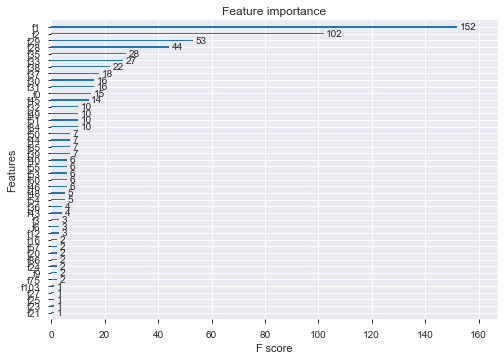

In [34]:
xgb.plot_importance(pipeline1._final_estimator)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

In [35]:
pipeline1.named_steps['vectorizer'].vocabulary_

{'Wochentag=Freitag': 0,
 'TagNr': 1,
 'WocheNr': 2,
 'isFreiZH': 3,
 'isFreiSG': 4,
 'isFreiGR': 5,
 'isFerienZH': 6,
 'Ferien Desc ZH': 7,
 'IsFerienZH_plus3': 8,
 'isFerienZH_minus3': 9,
 'isFerienSG': 10,
 'Ferien Desc SG': 11,
 'IsFerienSG_plus3': 12,
 'isFerienSG_minus3': 13,
 'isFerienGR': 14,
 'Ferien Desc GR': 15,
 'IsFerienGR_plus3': 16,
 'isFerienGR_minus3': 17,
 'Feiertag Desc=Neujahr': 18,
 'isFeiertag ZH': 19,
 'IsFeiertagZH_plus3': 20,
 'isFeiertagZH_minus3': 21,
 'isFeiertag SG': 22,
 'IsFeiertagSG_plus3': 23,
 'isFeiertagSG_minus3': 24,
 'isFeiertag GR': 25,
 'IsFeiertagGR_plus3': 26,
 'isFeiertagGR_minus3': 27,
 't_2m_c_avg': 28,
 'snow_depth_cm_avg': 29,
 'visibility_m_avg': 30,
 'wind_speed_10m_ms_max': 31,
 'prob_precip_1h_p_avg': 32,
 'prob_tstorm_1h_p_avg': 33,
 'hail_idx_avg': 34,
 'wind_gusts_10m_ms_max': 35,
 'wind_speed_mean_10m_24h_ms_avg': 36,
 't_max_2m_24h_c_max': 37,
 't_min_2m_24h_c_min': 38,
 'precip_24h_mm_max': 39,
 'fresh_snow_24h_cm_max': 40,
 'is_

In [36]:
def train_model(max_depth, 
                n_estimators,
                learning_rate):
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'learning_rate':learning_rate,
        'n_jobs': 8 #number of CPU threads
    }

    pipeline = Pipeline([
                     ("vectorizer", DictVectorizer(sort=False)),
                     ("clf", xgb.XGBRegressor(objective = 'reg:squarederror',**params)),

                        ])

    xgb_fit = pipeline.fit(X_train.to_dict("records"), y_train)
    preds = xgb_fit.predict(X_val.to_dict("records"))
    mse = mean_absolute_error(preds, y_test)
    return -mse

bounds = {
    'max_depth':(5,100),
    'n_estimators': (100,10000),
    'learning_rate': (.001, 0.1),
}


In [37]:
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=bounds,
    random_state=1,
    verbose=2,
)
best = optimizer.maximize(init_points=2, n_iter= 3)
print(optimizer.max)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
|  1        | -22.38    |  0.04229  |  73.43    |  101.1    |
|  2        | -22.13    |  0.03093  |  18.94    |  1.014e+0 |
|  3        | -20.85    |  0.04016  |  5.019    |  9.102e+0 |
|  4        | -22.33    |  0.001    |  100.0    |  6.301e+0 |
|  5        | -22.5     |  0.1      |  100.0    |  1e+04    |
{'target': -20.84704162588167, 'params': {'learning_rate': 0.040160109565017685, 'max_depth': 5.019122733910913, 'n_estimators': 9102.471257812776}}


In [73]:
params = {
    'n_estimators': 1000,
    'max_depth': 100,
    'learning_rate':0.001,
    'n_jobs': 8 #number of CPU threads
}

pipeline = Pipeline([
                 ("vectorizer", DictVectorizer(sort=False)),
                 ("clf", xgb.XGBRegressor(objective = 'reg:squarederror',**params)),

                    ])

xgb_fit = pipeline.fit(X_train.to_dict("records"), y_train)
preds = xgb_fit.predict(X_val.to_dict("records"))
mse = mean_absolute_error(preds, y_test)
mse

31.23644616236141

In [39]:
params2 = {
    'n_estimators': int(optimizer.max['params']['n_estimators']),
    'max_depth': int(optimizer.max['params']['max_depth']),
    'learning_rate':optimizer.max['params']['learning_rate'],
    'n_jobs': 8 #number of CPU threads
}

pipeline2 = Pipeline([
                     ("vectorizer", DictVectorizer(sort=False)),
                     ("clf", xgb.XGBRegressor(**params2))
                    ])

xgb_tuned_fit = pipeline2.fit(X_train.to_dict("records"), y_train)

[22:23:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [40]:
preds = xgb_tuned_fit.predict(X_val.to_dict("records"))
mse = mean_absolute_error(preds, y_test)
mse

20.84704162588167

In [50]:
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_file

df.sort_index(inplace=True)

source = ColumnDataSource(df)

p = figure(x_axis_type="datetime", plot_width=800, plot_height=350)
p.line(X_test[target_variable], preds)


KeyError: 'Schalter'

# Preprocessing Error